In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite", echo=False)


In [38]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine)

In [39]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [40]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [41]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [42]:
# Use inspector to check columns to see the data and data types in each table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

print('-----------------')

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
-----------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [53]:
# Find the most recent date in the data set.
most_recent_date = (session.query(Measurement.date).order_by(Measurement.date.desc()).first())[0]

2017-08-23


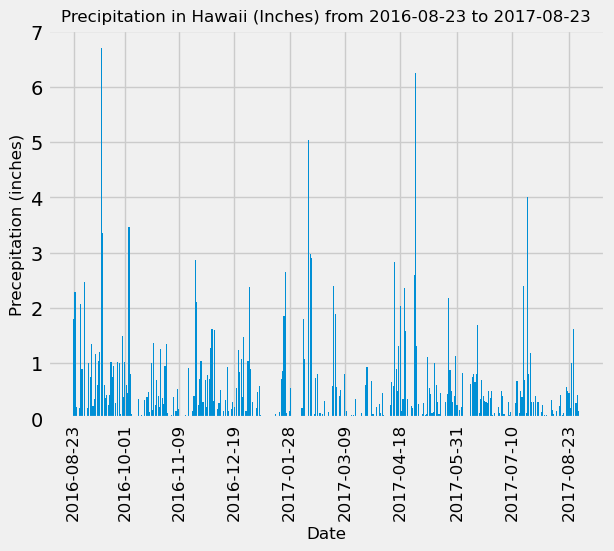

<Figure size 1000x1000 with 0 Axes>

In [88]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
first_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date >= '2016-08-23')

precipitation_rows = [{"Date": result[1], "Precipitation": result[0]} for result in results]

# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(precipitation_rows).dropna()

# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

x_ticks = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10', '2017-08-23']

plt.bar(prec_df.Date, prec_df.Precipitation)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Precepitation (inches)', fontsize=12)
plt.title('Precipitation in Hawaii (Inches) from 2016-08-23 to 2017-08-23', fontsize=12)
plt.xticks(x_ticks, rotation=90, fontsize=12)
plt.figure(figsize=(10,10))
plt.tight_layout()
plt.show()

In [90]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mean_prec = np.mean(prec_df.Precipitation)
med_prec = np.median(prec_df.Precipitation)
var_prec = np.var(prec_df.Precipitation)
std_prec = np.std(prec_df.Precipitation)

print(f'Mean Precipitation = {mean_prec} inches')
print(f'Median Precipitation = {med_prec} inches')
print(f'Variance of Precipitation = {var_prec} inches')
print(f'Standard Deviation of Precipitation = {std_prec} inches')

Mean Precipitation = 0.17727857496288996 inches
Median Precipitation = 0.02 inches
Variance of Precipitation = 0.2125905156666475 inches
Standard Deviation of Precipitation = 0.4610753904370168 inches


# Exploratory Station Analysis

In [101]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Measurement.station).distinct().count()

print(total_stations)

9


In [138]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.date)]

station_counts = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(sel[1].desc()).all()

station_counts

#Based on the results USC00519281,"WAIHEE 837.5, HI US" is the most active station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [149]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel2 = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

waihee_tobs = session.query(*sel2).\
    filter(Measurement.station == 'USC00519281').all()

waihee_tobs_df = pd.DataFrame(waihee_tobs, columns=['Station ID', 'Min Temp', 'Max Temp', 'Avg Temp'])
waihee_tobs_df.set_index('Station ID')

,Min Temp,Max Temp,Avg Temp
Station ID,,,
USC00519281,54.0,85.0,71.663781


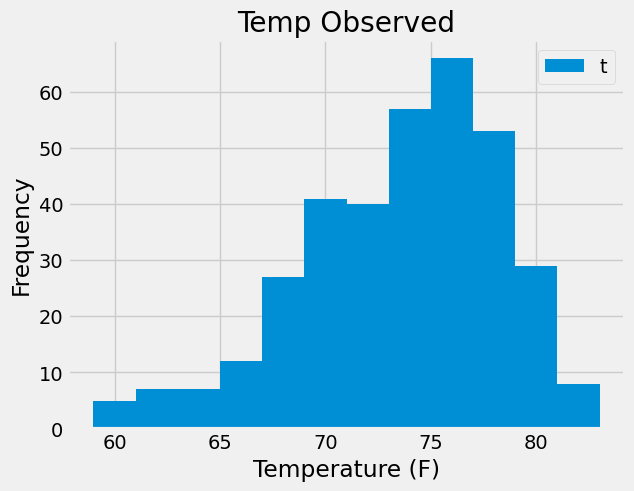

In [180]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
yr_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= '2016-08-23').all()

yr_tobs_df = pd.DataFrame(yr_tobs, columns=['Observation Date', 'Temp Observed'])

bins = yr_tobs_df.groupby(yr_tobs_df['Temp Observed']).count()

yr_tobs_df.hist(bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.legend('tobs')

# Close session

In [ ]:
# Close Session
session.close()